In [276]:
from fuzzingbook.ConcolicFuzzer import SimpleConcolicFuzzer, ConcolicTracer

def triangle(a, b, c):
    if a == b:
        if b == c:
            return 'equilateral'
        else:
            return 'isosceles'
    else:
        if b == c:
            return 'isosceles'
        else:
            if a == c:
                return 'isosceles'
            else:
                return 'scalene'

with ConcolicTracer() as _:
    print(_[triangle](1,2,3))


scalene


In [277]:
_.decls

{'triangle_a_int_1': 'Int',
 'triangle_b_int_2': 'Int',
 'triangle_c_int_3': 'Int'}

In [278]:
_.path

[Not(triangle_a_int_1 == triangle_b_int_2),
 Not(triangle_b_int_2 == triangle_c_int_3),
 Not(triangle_a_int_1 == triangle_c_int_3)]

In [279]:
def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ''
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i = i + 2
            found = 0
            v = 0
            for key in hex_values:
                if key == digit_high:
                    found = found + 1
                    v = hex_values[key] * 16
                    break
            for key in hex_values:
                if key == digit_low:
                    found = found + 1
                    v = v + hex_values[key]
                    break
            if found == 2:
                if v >= 128:
                    # z3.StringVal(urllib.parse.unquote('%80')) <-- bug in z3
                    raise ValueError("Invalid encoding")
                t = t + chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t = t + c
        i = i + 1
    return t



ConcolicTracer在with块中使用；语法tracer[function]在tracer中执行函数，同时捕捉条件。下面是一个关于cgi_decode()函数的例子。

In [280]:
with ConcolicTracer() as _:
    _[cgi_decode]('a%20d')

print(_.decls)
print(_.path)
print(_.zeval(python=True))

{'cgi_decode_s_str_1': 'String'}
[Not(str.substr(cgi_decode_s_str_1, 0, 1) == "+"), Not(str.substr(cgi_decode_s_str_1, 0, 1) == "%"), Not(str.substr(cgi_decode_s_str_1, 1, 1) == "+"), str.substr(cgi_decode_s_str_1, 1, 1) == "%", Not(str.substr(cgi_decode_s_str_1, 2, 1) == "0"), Not(str.substr(cgi_decode_s_str_1, 2, 1) == "1"), str.substr(cgi_decode_s_str_1, 2, 1) == "2", str.substr(cgi_decode_s_str_1, 3, 1) == "0", Not(str.substr(cgi_decode_s_str_1, 4, 1) == "+"), Not(str.substr(cgi_decode_s_str_1, 4, 1) == "%")]
('sat', {'s': "A%20"})


从ConcolicTracer获得的约束被添加到concolic fuzzer中，具体如下。

In [281]:
scf = SimpleConcolicFuzzer()
scf.add_trace(_, 'a%20d')

然后，协和模糊器使用添加的约束条件来指导其模糊处理，如下所示。
```python
scf = SimpleConcolicFuzzer()
for i in range(20):
    v = scf.fuzz()
    if v is None:
        break
    print(repr(v))
    with ExpectError(print_traceback=False):
        with ConcolicTracer() as _:
            _[cgi_decode](v)
    scf.add_trace(_, v)
```

SimpleConcolicFuzzer只是探索了样本输入所穿越的原始路径附近的所有路径。它使用一个简单的机制来探索它所知道的路径附近的路径，而除了代码路径之外，它对输入一无所知。

另一方面，ConcolicGrammarFuzzer知道输入的语法，并能从被模糊处理的对象那里收集反馈。它可以解除语法中遇到的一些约束，从而实现更深入的模糊处理。它的使用方法如下。

在关于信息流的章节中，我们已经看到动态污点如何通过指示输入的哪一部分到达有趣的地方来指导模糊处理。然而，动态污点跟踪在它所能传播的信息方面是有限的。例如，我们可能想探索当输入的某些属性发生变化时发生了什么。

例如，假设我们有一个函数factorial()，它返回其输入的阶乘值。

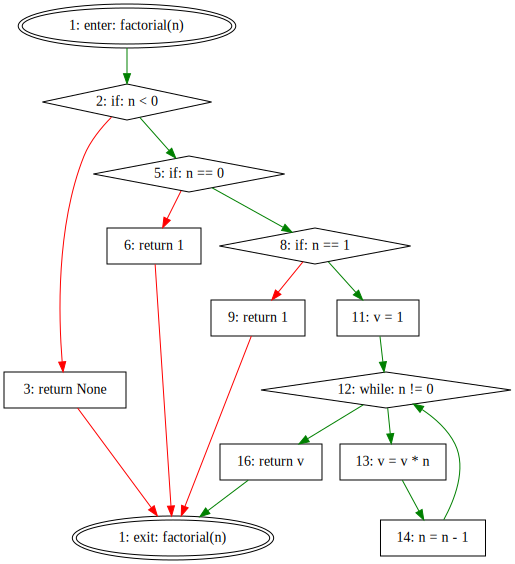

In [282]:
def factorial(n):
    if n < 0:
        return None

    if n == 0:
        return 1

    if n == 1:
        return 1

    v = 1
    while n != 0:
        v = v * n
        n = n - 1

    return v

from fuzzingbook.Coverage import Coverage

import inspect

class ArcCoverage(Coverage):
    def traceit(self, frame, event, args):
        if event != 'return':
            f = inspect.getframeinfo(frame)
            self._trace.append((f.function, f.lineno))
        return self.traceit

    def arcs(self):
        t = [i for f, i in self._trace]
        return list(zip(t, t[1:]))

with ArcCoverage() as cov:
    factorial(5)

from fuzzingbook.ControlFlow import to_graph, gen_cfg

to_graph(gen_cfg(inspect.getsource(factorial)), arcs=cov.arcs())

我们看到路径[1, 2, 5, 8, 11, 12, 13, 14]被覆盖（绿色），但子路径如[2, 3]、[5, 6]和[8, 9]则未被探索（红色）。我们需要的是产生输入的能力，使 "真 "分支在2处得到。

### Concolic Execution

覆盖额外分支的一种方法是查看正在采取的执行路径，并收集该路径所遇到的条件约束。然后我们可以尝试产生导致我们采取非遍历路径的输入。

首先，让我们踏过这个函数。

In [283]:
lines = [i[1] for i in cov._trace if i[0] == 'factorial']
src = {i + 1: s for i, s in enumerate(
    inspect.getsource(factorial).split('\n'))}

第(1)行只是该函数的入口点。我们知道，输入是n，是一个整数。

第(2)行是一个谓词n<0。由于下一个取的行是第(5)行，我们知道在执行路径的这一点上，该谓词是假的。

我们注意到这是一个没有采取真实分支的谓词。我们如何在这里生成一个采取真实分支的值呢？一种方法是使用符号变量来表示输入，对约束进行编码，并使用SMT求解器来解决约束的否定。

正如我们在本章介绍中提到的，符号变量可以被认为是实数变量的一种占位符，有点像代数中求解x时的x。这些变量可以用来编码放在程序中的变量上的约束。我们确定变量应该服从哪些约束，最后产生一个服从所有施加的约束的值。

In [284]:
print(src[1])
print(src[2], src[3], src[4], src[5])

def factorial(n):
    if n < 0:         return None      if n == 0:


## Solving Constraints

为了解决这些约束，我们可以使用Satisfiability Modulo Theories（SMT）求解器。SMT求解器是建立在SAT（Satisfiability）求解器之上的。SAT求解器被用来检查一阶逻辑中的布尔公式（如(a | b )& (~a | ~b)）是否可以用任何变量的赋值来满足（如a = true, b = false）。SMT求解器将这些SAT求解器扩展到特定的背景理论--例如，整数理论，或字符串理论。也就是说，给定一个用字符串变量表达的公式的字符串约束（例如h + t == 'hello,world'），一个理解字符串理论的SMT求解器可以用来检查这个约束是否可以被满足，如果可以满足，就为公式中的变量提供一个具体数值的实例（例如h = 'hello,', t = 'world'）。

In [285]:
import z3

z3_ver = z3.get_version()

print(z3_ver)

(4, 11, 2, 0)


In [286]:
assert z3_ver >= (4, 8, 13, 0), \
    f"Please install z3-solver 4.8.13.0 or later - you have {z3_ver}"

In [287]:
# 让我们首先设置Z3。为了确保我们在本章中使用的字符串约束被成功评估，我们需要指定z3str3求解器。此外，我们将Z3计算的超时时间设置为30秒。
z3.set_option('timeout', 30 * 1000)

In [288]:
print(cov.arcs())

[(1, 2), (2, 5), (5, 8), (8, 11), (11, 12), (12, 13), (13, 14), (14, 12), (12, 13), (13, 14), (14, 12), (12, 13), (13, 14), (14, 12), (12, 13), (13, 14), (14, 12), (12, 13), (13, 14), (14, 12), (12, 16), (16, 262), (262, 263)]


我们在这里所做的是使用具体的数值追踪与特定的输入阶乘(5)相对应的执行，同时保留符号的影子变量，使我们能够捕获约束。正如我们在介绍中提到的，这种使用符号变量跟踪具体执行的特殊执行方法被称为协同学执行。

我们如何使这个过程自动化呢？一种方法是使用类似于信息流一章的基础结构，使用Python的继承性来创建可以跟踪具体执行的符号代理对象。

## A Concolic Tracer

现在让我们定义一个类来收集执行过程中的符号变量和路径条件。我们的想法是有一个ConcolicTracer类，在一个with块中被调用。为了执行一个函数，同时追踪其路径条件，我们需要转换其参数，我们通过[]项的访问来调用函数。
现在让我们实现ConcolicTracer的构造函数，它接受一个单一的上下文参数，其中包含到目前为止看到的符号变量的声明和到目前为止看到的路径条件。我们只需要在嵌套上下文的情况下这样做。

我们现在定义了可用于协程跟踪的协程代理对象。首先，我们定义了zproxy_create()方法，给定一个类名，正确地创建该类的实例，以及符号化的对应变量，并将符号化的变量注册到上下文信息环境中。

In [289]:
def zproxy_create(cls, z_type, z3var, context, z_name, v=None):
    z_value = cls(context, z3var(z_name), v)
    context[0][z_name] = z_type  # add to decls
    return z_value

首先，我们定义了zbool类，用于跟踪遇到的谓词。它是一个封装类，包含符号（z）和具体（v）值。具体的值用来决定采取哪条路径，而符号值用来收集遇到的谓词。

初始化分两部分进行。第一部分是使用zproxy_create()来正确地初始化和注册与传递的参数相对应的影子符号变量。这是在符号变量需要先被初始化的时候专门使用的。在所有其他情况下，构造函数是用预先存在的符号值调用的。

In [290]:
class zbool:
    @classmethod
    def create(cls, context, z_name, v):
        return zproxy_create(cls, 'Bool', z3.Bool, context, z_name, v)

    def __init__(self, context, z, v=None):
        self.context = context
        self.z = z
        self.v = v
        self.decl, self.path = self.context

下面是它的使用方法。我们在concolic tracer的当前上下文中创建一个符号变量my_bool_arg，其值为True。

In [291]:
with ConcolicTracer() as _:
    val = zbool.create(_.context, 'my_bool_arg', True)

请注意，包围ConcolicTracer()的上下文被自动更新（通过zproxy_create()），以保持变量声明和类型。

#### Negation of Encoded formula

In [292]:
class zbool(zbool):
    def __not__(self):
        return zbool(self.context, z3.Not(self.z), not self.v)

with ConcolicTracer() as _:
    val = zbool.create(_.context, 'my_bool_arg', True)

_.context

({'my_bool_arg': 'Bool'}, [])

### 注册条件语的谓语



zbool类被用来跟踪程序执行中出现的布尔条件。它通过在上下文中注册相应的符号表达式来跟踪这些条件，只要它被评估。在评估时，__bool__()方法被调用；所以我们可以钩住这个方法。

zint类经常被用来做算术，或与其他ints进行比较。这些ints可以是一个变量，也可以是一个常量值。我们定义了一个辅助方法_zv()，它可以检查给定值是哪种类型的int，并产生正确的符号等值。

In [293]:
class zint(int):
    def __new__(cls, context, zn, v, *args, **kw):
        return int.__new__(cls, v, *args, **kw)
    
    def __int__(self):
        return self.v

    def __pos__(self):
        return self.v

class zint(zint):
    @classmethod
    def create(cls, context, zn, v=None):
        return zproxy_create(cls, 'Int', z3.Int, context, zn, v)

    def __init__(self, context, z, v=None):
        self.z, self.v = z, v
        self.context = context

with ConcolicTracer() as _:
    val = zint.create(_.context, 'int_arg', 0)

print(val.v)
print(_.context)

0
({'int_arg': 'Int'}, [])


zint类经常被用来做算术，或与其他ints进行比较。这些ints可以是一个变量，也可以是一个常量值。我们定义了一个辅助方法_zv()，它可以检查给定值是哪种类型的int，并产生正确的符号等值。

In [295]:
class zint(zint):
    def _zv(self, o):
        return (o.z, o.v) if isinstance(o, zint) else (z3.IntVal(o), o)

with ConcolicTracer() as _:
    val = zint.create(_.context, 'int_arg', 0)

val._zv(0)

(0, 0)

In [296]:


def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ''
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i = i + 2
            found = 0
            v = 0
            for key in hex_values:
                if key == digit_high:
                    found = found + 1
                    v = hex_values[key] * 16
                    break
            for key in hex_values:
                if key == digit_low:
                    found = found + 1
                    v = v + hex_values[key]
                    break
            if found == 2:
                if v >= 128:
                    # z3.StringVal(urllib.parse.unquote('%80')) <-- bug in z3
                    raise ValueError("Invalid encoding")
                t = t + chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t = t + c
        i = i + 1
    return t


from fuzzingbook.ConcolicFuzzer import ConcolicTracer, SimpleConcolicFuzzer

scf = SimpleConcolicFuzzer()
scf.add_trace(_, 'a+c')

({'round10_r_int_1': 'Int'}, [])

In [1]:
from fuzzingbook.ConcolicFuzzer import ConcolicTracer, SimpleConcolicFuzzer

def factorial(n):
    v = 1
    while n != 0:
        v *= n
        n -= 1

    return v

def permutation(n, k):
    return factorial(n) / factorial(n - k)

def combination(n, k):
    return permutation(n, k) / factorial(k)

def binomial(n, k):
    if n < 0 or k < 0 or n < k:
        raise Exception('Invalid values')
    return combination(n, k)

with ConcolicTracer() as _:
    v = _[binomial](4, 2)

_.zeval()


('sat', {'n': None, 'k': ('1', 'Int')})

In [2]:
from fuzzingbook.ConcolicFuzzer import ConcolicTracer

def factorial(n):
    v = 1
    while n != 0:
        v *= n
        n -= 1

    return v

def permutation(n, k):
    return factorial(n) / factorial(n - k)

def combination(n, k):
    return permutation(n, k) / factorial(k)

def binomial(n, k):
    if n < 0 or k < 0 or n < k:
        raise Exception('Invalid values')
    return combination(n, k)

with ConcolicTracer() as _:
    v = _[binomial](4, 2)

_.zeval()

('sat', {'n': None, 'k': ('1', 'Int')})